# 1. 작업환경 구성하기

In [213]:
# 모듈 임포트

import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline




# 2. 데이터셋 구성하기

In [214]:
# 데이터 로드
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

In [215]:
# 데이터 정규화 : 이미지를 -1~1 사이 값으로 정규화

train_x = (train_x - 127.5) / 127.5 

print(train_x.max())
print(train_x.min())
print(train_x.shape)

1.0
-1.0
(50000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


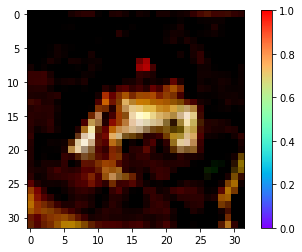

In [216]:
# CNN 계층 형식에 맞게 이미지에 차원 추가 및 이미지 확인

train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')

plt.imshow(train_x[0].reshape(32,32, 3), cmap='rainbow')
plt.colorbar()
plt.show()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

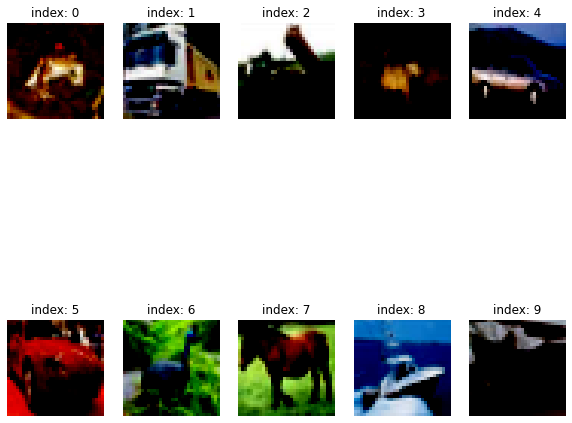

In [217]:
# 이미지 10개 확인

plt.figure(figsize=(10,10))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32,32,3),cmap='rainbow')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()
    

In [218]:
# tf.dataset으로 변환 : 데이터 섞고 배치 사이즈에 따라 나누기

BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 3. 생성자 모델 구현하기

In [219]:
# 생성자 모델 생성 함수 만들기

def make_generator_model():

    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2Transpose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

    return model
    


In [220]:
# 생성자 모델 실행 및 확인

generator = make_generator_model()

generator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_18 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 8, 8, 128)       

In [221]:
# 랜덤 노이즈 벡터(shape=(1,100)) 생성

noise = tf.random.normal([1, 100])


(1, 32, 32, 3)


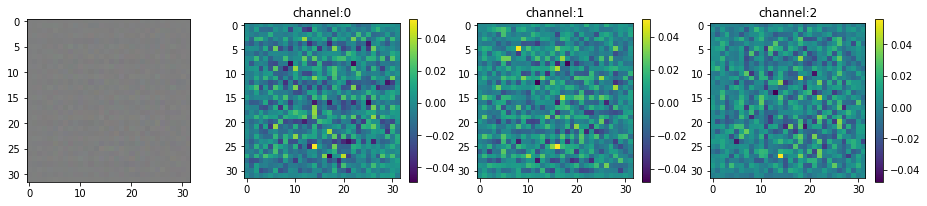

In [222]:
# 이미지 생성하기 및 시각화

generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.figure(figsize=(16,3))
plt.subplot(1, 4, 1)
plt.imshow((generated_image[0, :, :, :]+1)/2)
for i in range(3):
    plt.subplot(1, 4, (i+1)+1)
    plt.imshow(generated_image[0, :, :, i])
    plt.title("channel:{}".format(i))
    plt.colorbar()
plt.show()

# 4. 판별자 모델 구현하기

In [223]:
# 판별자 모델 생성 함수 만들기

def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2,2), padding='same', input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [224]:
# 판별자 모델 생성 및 summary 출력

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)            

In [225]:
# 생성 이미지 판별자에 입력

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0004018]], dtype=float32)>

# 5. 손실함수와 최적화 함수 구현하기

In [226]:
# 손실함수에 사용할 크로스엔트로피 함수 정의(가짜인지 진짜인지 구분하는 용도)

    # from_logits를 활용하여 정규화 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [227]:
# generator_loss 함수 만들기

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [228]:
# discriminator_loss 함수 만들기

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss  

In [229]:
# discriminator_accuracy 함수 만들기
    # 함수값이 0.5에 가까워지는 게 이상적

def discriminator_accuracy(real_output, fake_output):
    
    # 1. tf.math.greater_equal(real_output, tf.constant([0.5])) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
    # tf.cast(1, tf.float(32)) : 1의 결과가 True이면 1.0, False면 0.0으로 변환
    # tf.reduce_mean(2) : 2의 결과를 평균하여 해당 배치의 정확도 계산
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy


In [230]:
# 최적화 함수 구하기
    # learning rate = 0.0001로 설정
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [231]:
# 학습 진행과정 확인을 위한 seed 노이즈 생성

    # 100차원의 노이즈 16개로 구성된 (16,100) 사이즈 노이즈 벡터 만들기
    
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 6. 훈련과정 상세 기능 구현하기

In [232]:
# train_step 함수 생성
    # @tf.function 데코레이터의 경우, 입력값이 tensorflow graph의 노드가 될 수 있는 타입으로 자동 변환됨
    
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [233]:
# 샘플 16개 추출 후 시각화

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()
        

In [234]:
# train_step() 함수의 return값(gen_loss, disc_loss, real_accuracy, fake_accuracy) 매 epoch마다 시각화

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [235]:
# 체크포인트 모델 저장

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 7. 학습 과정 진행하기

In [236]:
# 모델 학습 함수 만들기
    # 한단계 학습하는 train_step, 
    # 샘플이미지를 생성하고 저장하는 generated_and_save_images(),
    # 학습과정을 시각화 하는 draw_train_history(),
    # 모델을 저장하는 checkpoint 합치기
    
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [237]:
# 모델 학습

save_every = 5
EPOCHS = 50



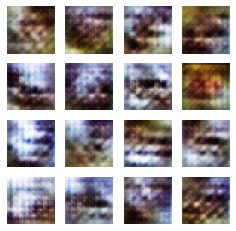

Time for training : 609 sec


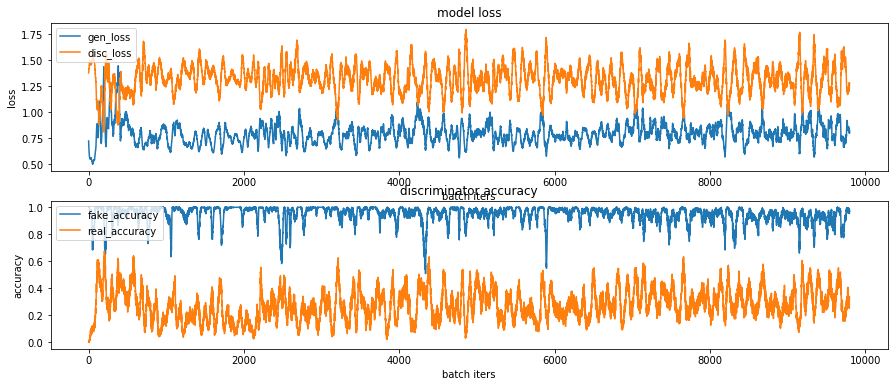

CPU times: user 11min 7s, sys: 1min 14s, total: 12min 22s
Wall time: 10min 9s


In [238]:
%%time
train(train_dataset, EPOCHS, save_every)